# Single label Classifier - AF Detection

Using the dataset provided by the 2020 Physionet Challenge we've developed an Atrial Fibrilation Detector trained to identify AF diagnosed patiences from a dataset containing patiances with different pathologies like: PAC, RBBB, I-AVB, PVC, LBBB, STD, STE and healthy individuals.

Although data from 12-lead ECG was provided, for this first analysis we've only used the lead 2 data and we've processed the signals in order to create a dataframe consisting of features we believe will help us classify.


In [1]:
import sys
import os

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy

from xverse.transformer import WOE

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from IPython.display import display

from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

import mlflow
import mlflow.sklearn

%matplotlib inline
import plotly.express as px
import seaborn as sns

## Now we can choose which lead data to load

### Lead 2 data seems to give better results:

In [2]:
ls datasets

phys-raw-lead2-HRV-corrected


In [3]:
lead = 'HRV-lead2'
df_raw = pd.read_feather('datasets/phys-raw-lead2-HRV-corrected')
df_raw.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_pNN50', 'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'mean_P_Peaks', 'age',
       'label'],
      dtype='object')

In [4]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

AF        I-AVB         LBBB       Normal          PAC  \
count  6877.000000  6877.000000  6877.000000  6877.000000  6877.000000   
mean      0.177548     0.104988     0.028937     0.133488     0.079104   
std       0.382160     0.306560     0.167642     0.340127     0.269921   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               PVC         RBBB          STD          STE  
count  6877.000000  6877.000000  6877.000000  6877.000000  
mean      0.091173     0.243566     0.114294     0.026901  
std       0.287877     0.429265     0.318191     0.161807  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000

In [5]:
df_raw = df_raw.loc[df_raw['age'] >= 0]

## Removing Redundant Features

By calculating a Dendrogram we look for features that may be providing the same information so we can remove them and end up with a cleaner model.

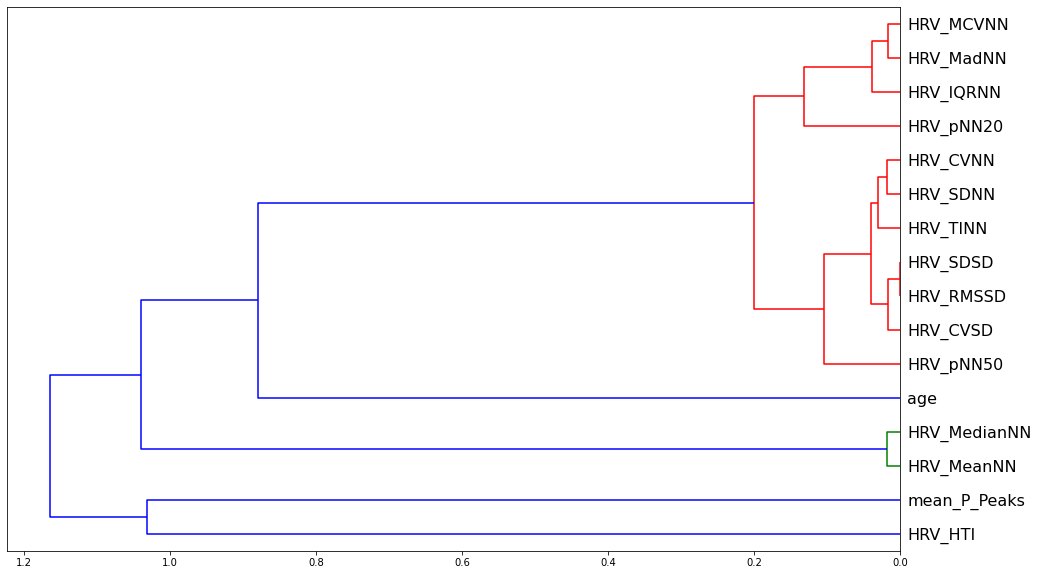

In [6]:
corr = np.round(scipy.stats.spearmanr(df_raw.drop('label',axis=1)).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_raw.drop('label',axis=1).columns, orientation='left', leaf_font_size=16)
plt.show()

Given that the variance can be obtained from the std, and viceversa it's no surprise they seem to provide the same information. Let's try and remove them.

In [7]:
to_drop = ['HRV_SDSD']
df_raw = df_raw.drop(to_drop, axis=1)

<AxesSubplot:>

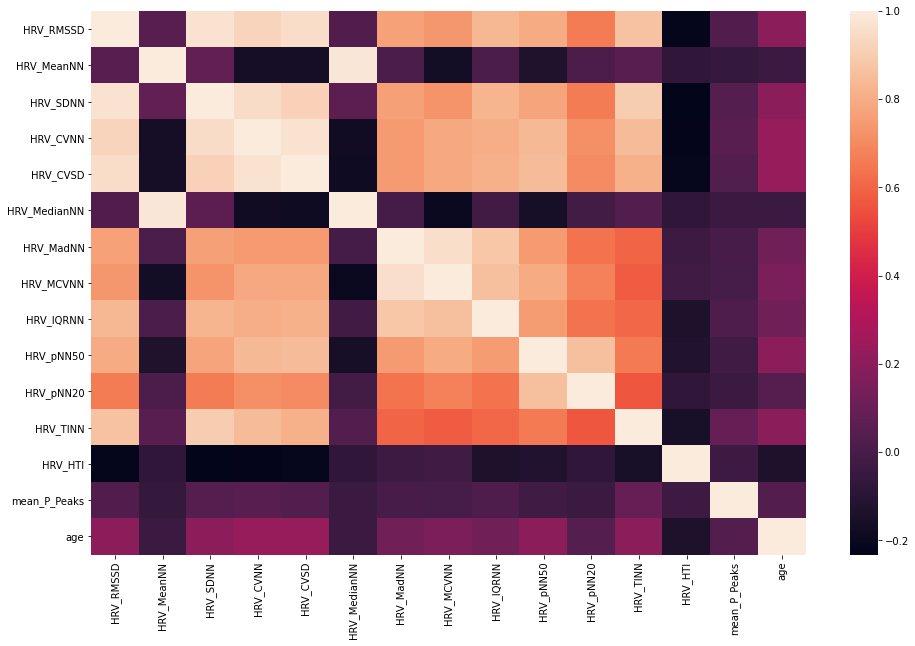

In [8]:
plt.figure(figsize=(16,10))
sns.heatmap(df_raw.corr())

### Renaming everything else as "Non-AF" in both sets

In [9]:
df_raw.loc[df_raw.label != 'AF', 'label'] = 'Non-AF'

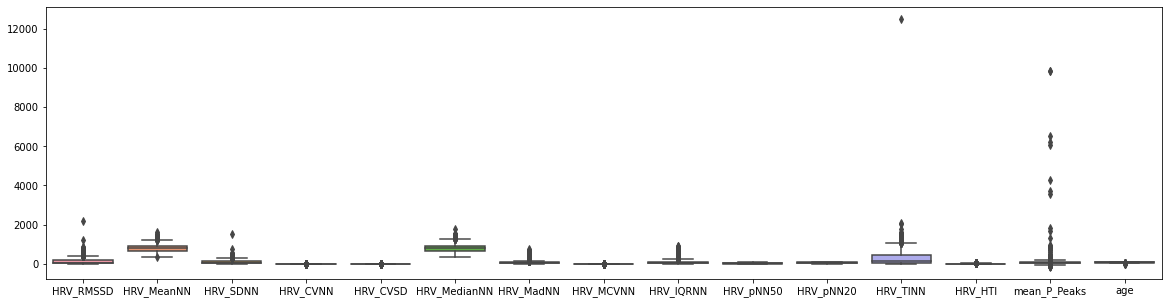

In [10]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df_raw)
plt.show()

Seems to be an outlier so we'll remove that one from our dataset

In [11]:
#df_raw = df_raw.drop(df_raw.loc[df_raw.HRV_TINN > 12000,'HRV_TINN'].index)
#df_raw = df_raw.drop(df_raw.loc[df_raw.mean_P_Peaks > 1000,'mean_P_Peaks'].index)

In [12]:
df = df_raw.copy()
cols = df_raw.columns
cols = cols.drop('label')
for col in cols:
    df = df[df[col] < df[col].quantile(.99)]
    
df_raw = df.copy()

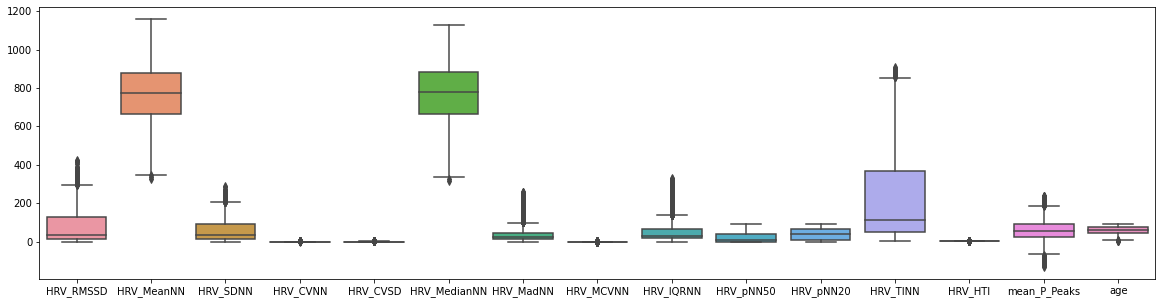

In [13]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df_raw)
plt.show()

CPU times: user 1min 2s, sys: 410 ms, total: 1min 2s
Wall time: 1min 2s


<Figure size 2160x720 with 0 Axes>

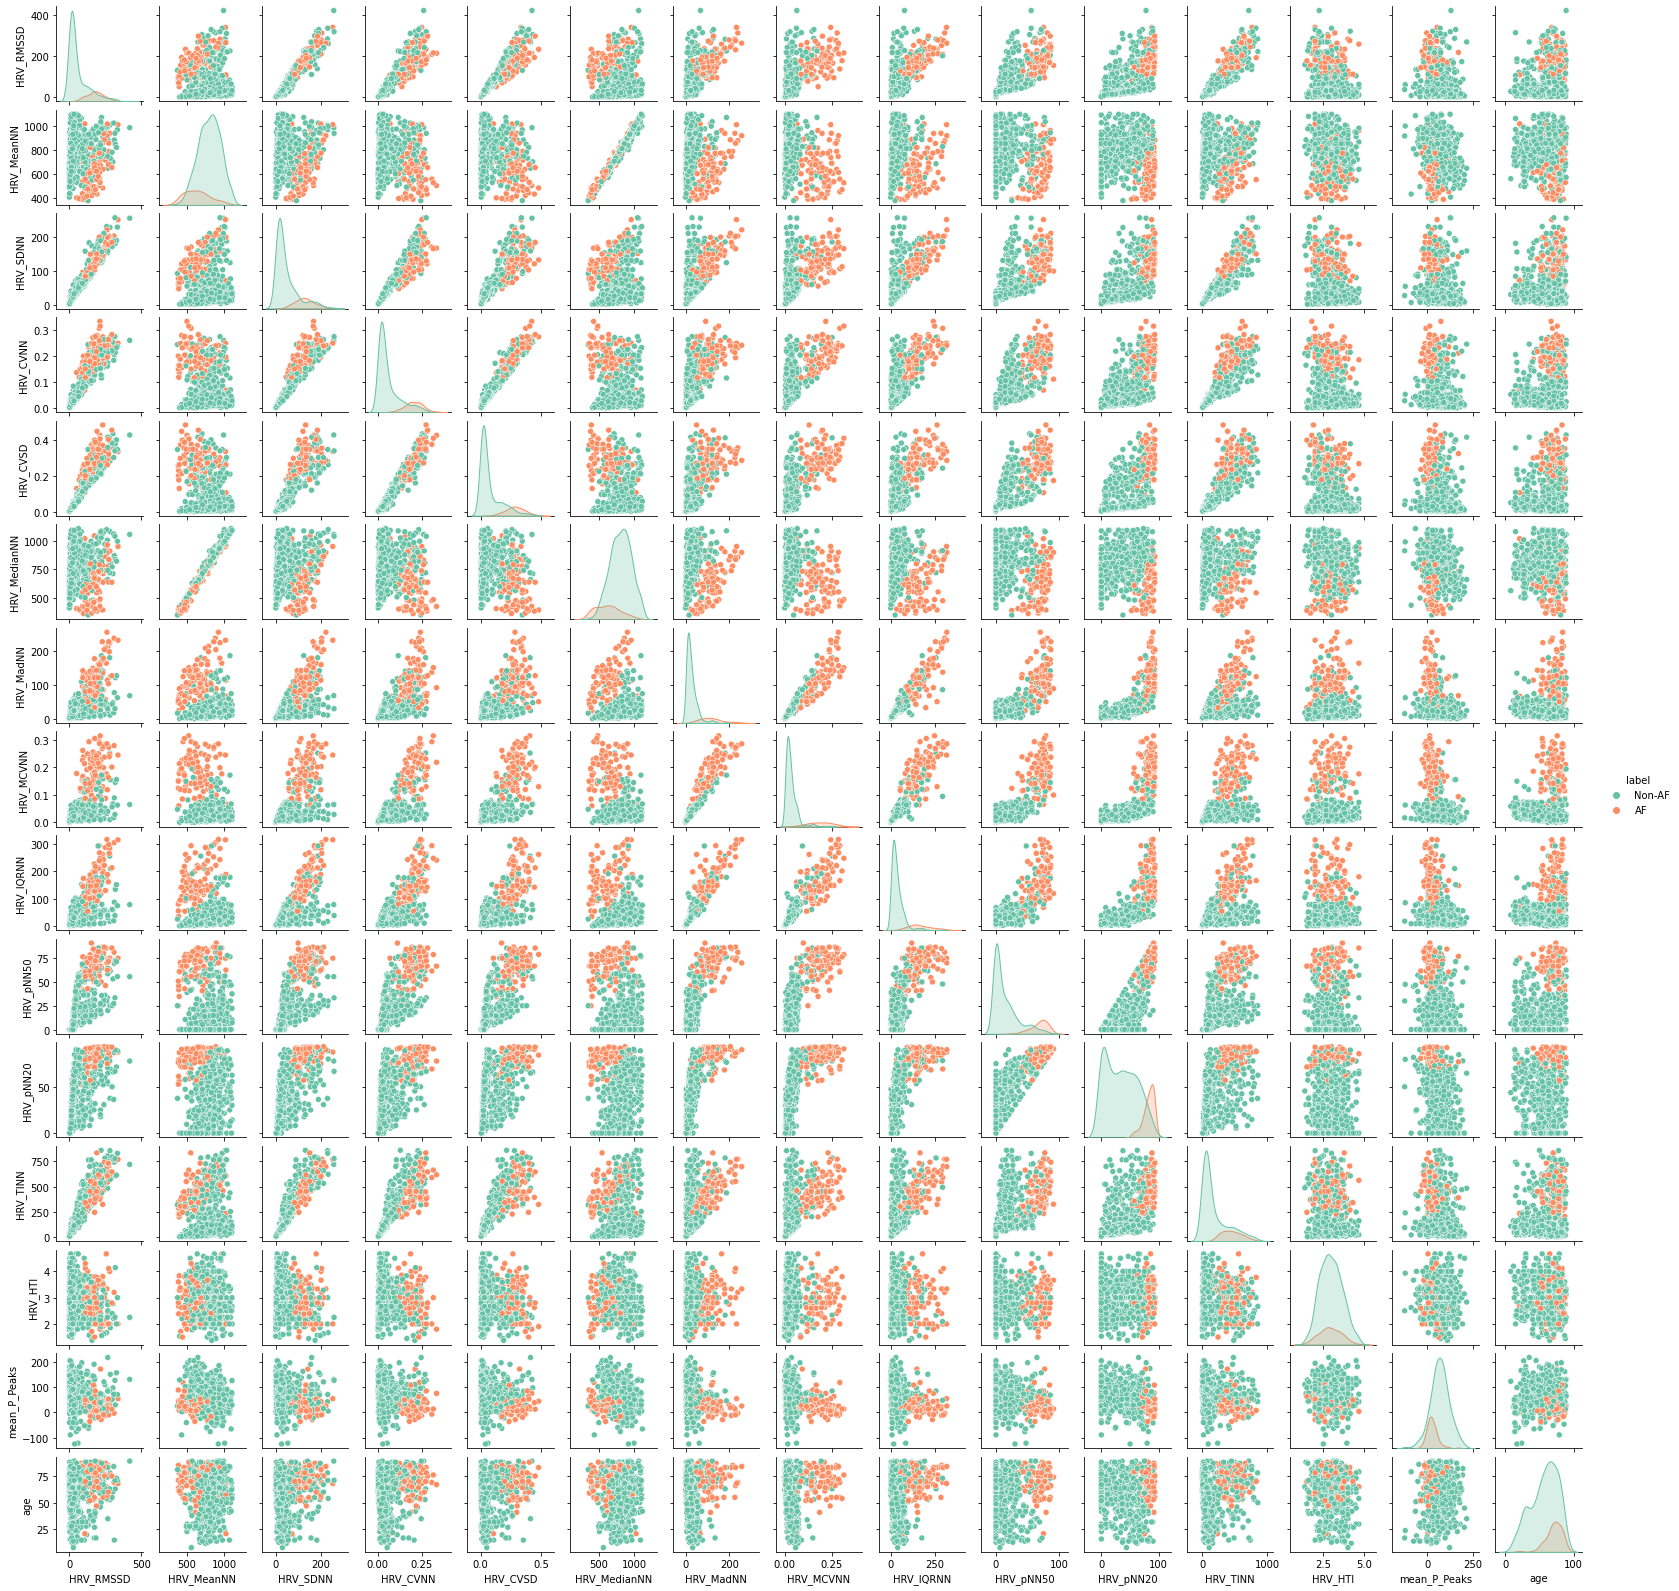

In [14]:
plt.figure(figsize=(30,10))
%time sns.pairplot(data=df_raw.sample(frac=0.1, random_state=42), hue='label', palette='Set2', height=1.5)
plt.show()

## Split between Train and Validation Datasets

### Training Set (80%) - Validation (20%)

In [15]:
y = df_raw['label']
X = df_raw.drop('label', axis=1)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

## We check for missing values

In [16]:
df_raw.isnull().sum()

HRV_RMSSD       0
HRV_MeanNN      0
HRV_SDNN        0
HRV_CVNN        0
HRV_CVSD        0
HRV_MedianNN    0
HRV_MadNN       0
HRV_MCVNN       0
HRV_IQRNN       0
HRV_pNN50       0
HRV_pNN20       0
HRV_TINN        0
HRV_HTI         0
mean_P_Peaks    0
age             0
label           0
dtype: int64

## Evaluation Metrics

This are the evaluation metrics we are actually interested in.

In [17]:
res = pd.DataFrame({'model':[], 'f1':[]})

### We process our datasets and train our model

In [18]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(X_train, y_train)

f1_score(y_eval, lr.predict(X_eval), pos_label='AF')

CPU times: user 37.5 ms, sys: 68 ms, total: 105 ms
Wall time: 1.55 s


0.9198966408268733

In [19]:
res = res.append({'model':'Logistic Regression',
                  'f1': f1_score(y_eval, lr.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [20]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(X_train, y_train)

f1_score(y_eval, rf.predict(X_eval), pos_label='AF')

CPU times: user 2 s, sys: 245 ms, total: 2.25 s
Wall time: 755 ms


0.9269521410579346

In [21]:
res = res.append({'model':'Random Forest',
                  'f1': f1_score(y_eval, rf.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [22]:
svc = SVC()

%time svc.fit(X_train, y_train)

f1_score(y_eval, svc.predict(X_eval), pos_label='AF')

CPU times: user 281 ms, sys: 7.65 ms, total: 288 ms
Wall time: 286 ms


0.928759894459103

In [23]:
res = res.append({'model':'SVC',
                  'f1': f1_score(y_eval, svc.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [24]:
knn = KNeighborsClassifier(n_jobs=4)

%time knn.fit(X_train, y_train)

f1_score(y_eval, knn.predict(X_eval), pos_label='AF')

CPU times: user 15.3 ms, sys: 3.85 ms, total: 19.1 ms
Wall time: 18.2 ms


0.918781725888325

In [25]:
res = res.append({'model':'KNN',
                  'f1': f1_score(y_eval, knn.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [26]:
res.sort_values('f1', ascending=False)

model        f1
2                  SVC  0.928760
1        Random Forest  0.926952
0  Logistic Regression  0.919897
3                  KNN  0.918782

## Let's try a Standard Scaler

In [27]:
scal = StandardScaler()
xtrain_scal = scal.fit_transform(X_train)
xeval_scal = scal.transform(X_eval)

In [28]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(xtrain_scal, y_train)

f1_score(y_eval, lr.predict(xeval_scal), pos_label='AF')

CPU times: user 10.7 ms, sys: 82 µs, total: 10.8 ms
Wall time: 412 ms


0.923076923076923

In [29]:
res = res.append({'model':'Logistic Regression Scal',
                  'f1': f1_score(y_eval, lr.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [30]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(xtrain_scal, y_train)

f1_score(y_eval, rf.predict(xeval_scal), pos_label='AF')

CPU times: user 1.44 s, sys: 188 ms, total: 1.63 s
Wall time: 495 ms


0.9191919191919191

In [31]:
res = res.append({'model':'Random Forest Scal',
                  'f1': f1_score(y_eval, rf.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [32]:
svc = SVC()

%time svc.fit(xtrain_scal, y_train)

f1_score(y_eval, svc.predict(xeval_scal), pos_label='AF')

CPU times: user 208 ms, sys: 6 µs, total: 208 ms
Wall time: 207 ms


0.9336734693877551

In [33]:
res = res.append({'model':'SVC Scal',
                  'f1': f1_score(y_eval, svc.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [34]:
knn = KNeighborsClassifier()

%time knn.fit(xtrain_scal, y_train)

f1_score(y_eval, knn.predict(xeval_scal), pos_label='AF')

CPU times: user 15.7 ms, sys: 0 ns, total: 15.7 ms
Wall time: 14.7 ms


0.9113300492610837

In [35]:
res = res.append({'model':'KNN Scal',
                  'f1': f1_score(y_eval, knn.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [36]:
res.sort_values('f1', ascending=False)

model        f1
6                  SVC Scal  0.933673
2                       SVC  0.928760
1             Random Forest  0.926952
4  Logistic Regression Scal  0.923077
0       Logistic Regression  0.919897
5        Random Forest Scal  0.919192
3                       KNN  0.918782
7                  KNN Scal  0.911330

### Let's check and see if there's a polynomical relation between features

In [37]:
X_train.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_CVNN', 'HRV_CVSD',
       'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'mean_P_Peaks', 'age'],
      dtype='object')

In [38]:
xpol_train = X_train.drop('age', axis=1)
xpol_eval = X_eval.drop('age', axis=1)

poly = PolynomialFeatures(2, include_bias=False)

xtrain_poly = poly.fit_transform(xpol_train)
xeval_poly = poly.transform(xpol_eval)

xtrain_poly = np.c_[xtrain_poly, X_train.age]
xeval_poly = np.c_[xeval_poly, X_eval.age]

scal = StandardScaler()
xtrain_poly = scal.fit_transform(xtrain_poly)
xeval_poly = scal.transform(xeval_poly)

In [39]:
xtrain_poly.shape

(4681, 120)

In [40]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(xtrain_poly, y_train)

f1_score(y_eval, lr.predict(xeval_poly), pos_label='AF')

CPU times: user 10.7 ms, sys: 3.96 ms, total: 14.6 ms
Wall time: 1.71 s


0.9329896907216495

In [41]:
res = res.append({'model':'Logistic Regression Poly',
                  'f1': f1_score(y_eval, lr.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [42]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(xtrain_poly, y_train)

f1_score(y_eval, rf.predict(xeval_poly), pos_label='AF')

CPU times: user 5.79 s, sys: 244 ms, total: 6.03 s
Wall time: 1.66 s


0.9316455696202532

In [43]:
res = res.append({'model':'Random Forest Poly',
                  'f1': f1_score(y_eval, rf.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [44]:
svc = SVC()

%time svc.fit(xtrain_poly, y_train)

f1_score(y_eval, svc.predict(xeval_poly), pos_label='AF')

CPU times: user 773 ms, sys: 23 µs, total: 773 ms
Wall time: 772 ms


0.9254498714652957

In [45]:
res = res.append({'model':'SVC Poly',
                  'f1': f1_score(y_eval, svc.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [46]:
knn = KNeighborsClassifier(n_jobs=4)

%time knn.fit(xtrain_poly, y_train)

f1_score(y_eval, knn.predict(xeval_poly), pos_label='AF')

CPU times: user 58.1 ms, sys: 85 µs, total: 58.2 ms
Wall time: 57 ms


0.9104477611940298

In [47]:
res = res.append({'model':'KNN Poly',
                  'f1': f1_score(y_eval, knn.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [48]:
res.sort_values('f1', ascending=False)

model        f1
6                   SVC Scal  0.933673
8   Logistic Regression Poly  0.932990
9         Random Forest Poly  0.931646
2                        SVC  0.928760
1              Random Forest  0.926952
10                  SVC Poly  0.925450
4   Logistic Regression Scal  0.923077
0        Logistic Regression  0.919897
5         Random Forest Scal  0.919192
3                        KNN  0.918782
7                   KNN Scal  0.911330
11                  KNN Poly  0.910448

## We take a look at Principal Component Analysis

In [49]:
n_comps = X_train.shape[1]

pca = PCA(n_components = n_comps)

train_pca = pca.fit_transform(xtrain_scal)

eval_pca = pca.transform(xeval_scal)

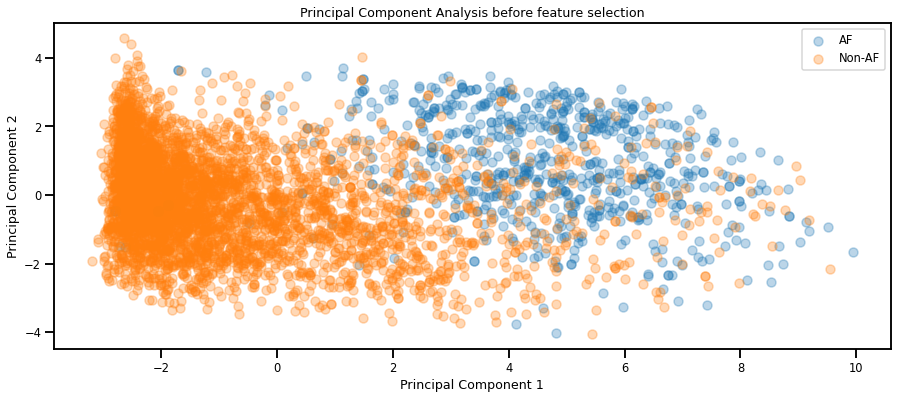

In [50]:
xpca = pd.DataFrame(train_pca)

sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))
plt.scatter(xpca.loc[(y_train == 'AF').ravel(),0],xpca.loc[(y_train == 'AF').ravel(),1], alpha = 0.3, label = 'AF')
plt.scatter(xpca.loc[(y_train == 'Non-AF').ravel(),0],xpca.loc[(y_train == 'Non-AF').ravel(),1], alpha = 0.3, label = 'Non-AF')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

In [51]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(train_pca, y_train)

f1_score(y_eval, lr.predict(eval_pca), pos_label='AF')

CPU times: user 11.6 ms, sys: 164 µs, total: 11.8 ms
Wall time: 490 ms


0.923076923076923

In [52]:
res = res.append({'model':'Logistic Regression PCA',
                  'f1': f1_score(y_eval, lr.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [53]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(train_pca, y_train)

f1_score(y_eval, rf.predict(eval_pca), pos_label='AF')

CPU times: user 2.21 s, sys: 217 ms, total: 2.43 s
Wall time: 720 ms


0.928759894459103

In [54]:
res = res.append({'model':'Random Forest PCA',
                  'f1': f1_score(y_eval, rf.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [55]:
svc = SVC()

%time svc.fit(train_pca, y_train)

f1_score(y_eval, svc.predict(eval_pca), pos_label='AF')

CPU times: user 237 ms, sys: 7 µs, total: 237 ms
Wall time: 234 ms


0.9336734693877551

In [56]:
res = res.append({'model':'SVC PCA',
                  'f1': f1_score(y_eval, svc.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [57]:
knn = KNeighborsClassifier(n_jobs=4)

%time knn.fit(train_pca, y_train)

f1_score(y_eval, knn.predict(eval_pca), pos_label='AF')

CPU times: user 7.57 ms, sys: 7.6 ms, total: 15.2 ms
Wall time: 13.9 ms


0.9113300492610837

In [58]:
res = res.append({'model':'KNN PCA',
                  'f1': f1_score(y_eval, knn.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [59]:
res.sort_values('f1', ascending=False)

model        f1
6                   SVC Scal  0.933673
14                   SVC PCA  0.933673
8   Logistic Regression Poly  0.932990
9         Random Forest Poly  0.931646
2                        SVC  0.928760
13         Random Forest PCA  0.928760
1              Random Forest  0.926952
10                  SVC Poly  0.925450
4   Logistic Regression Scal  0.923077
12   Logistic Regression PCA  0.923077
0        Logistic Regression  0.919897
5         Random Forest Scal  0.919192
3                        KNN  0.918782
7                   KNN Scal  0.911330
15                   KNN PCA  0.911330
11                  KNN Poly  0.910448

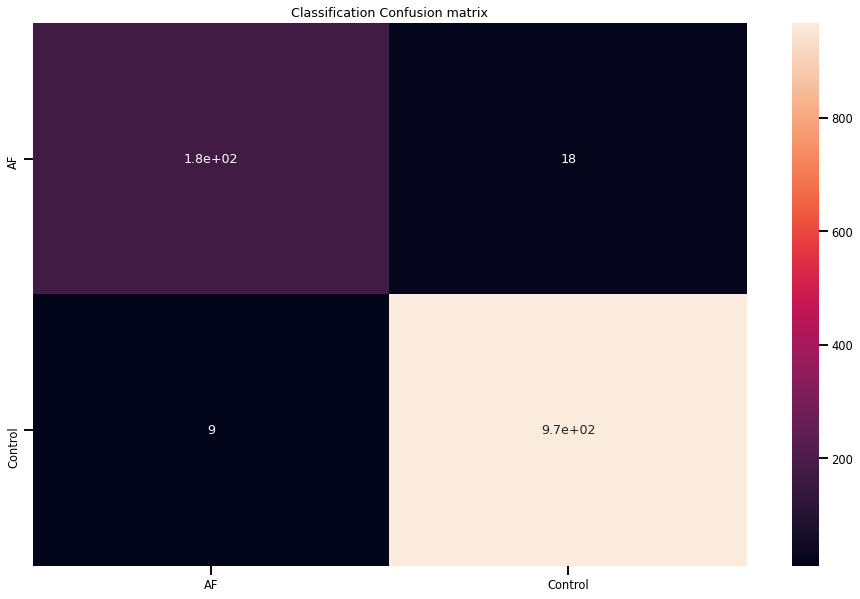

In [60]:
ypred = rf.predict(eval_pca)

cm = confusion_matrix(y_eval, ypred)

df_cm = pd.DataFrame(cm, index = ['AF', 'Control'], columns = ['AF', 'Control'])
plt.figure(figsize = (16,10))
sns.heatmap(df_cm, annot=True)
plt.title('Classification Confusion matrix')
plt.show()

## Confidence based on Tree Variance

We take a look at the standard deviation among trees to see how confident we are about each classification. 

In [61]:
preds = np.stack([t.predict(eval_pca) for t in rf.estimators_])

### We use the statistical Bootstrap Method

The bootstrap method is a popular non-parametric method, which does not require any distributional assumptions. Efron and Tibshirani provide a detailed review of the bootstrap method. The following is an algorithmic approach of obtaining a (1−α)100% percentile bootstrap conﬁdence interval for the population mean.

In [63]:
from sklearn.utils import resample

n_iterations = 300
n_size = int(len(preds) * 0.60)

Lowers = []
Uppers = []

for i in range(len(preds[0])):
    
    means = []
    
    for _ in range(n_iterations):
        rs = resample(preds[:, i], n_samples=n_size, replace=True)
        means.append(np.mean(rs))
    
    alpha = 0.99
    p = ((1.0 - alpha) / 2.0) * 100
    lower = max(0.0, np.percentile(means, p))
    Lowers.append(lower)
    
    p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    upper = min(1.0, np.percentile(means, p))
    Uppers.append(upper)

In [74]:
y_eval = pd.Categorical(y_eval)
y = y_eval.codes

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [75]:
X = pd.DataFrame(eval_pca)

X['actuals'] = y
X['preds'] = np.mean(preds, axis=0)
X['std'] = (np.std(preds, axis=0))
X['upper'] = Uppers - np.mean(preds, axis=0)
X['lower'] = np.mean(preds, axis=0) - Lowers
X['var'] = (np.var(preds, axis=0))
flds = ['actuals', 'preds', 'std', 'var', 'upper', 'lower']
X.loc[:5,flds]

actuals  preds       std     var     upper     lower
0        1   0.93  0.255147  0.0651  0.053333  0.088417
1        1   1.00  0.000000  0.0000  0.000000  0.000000
2        1   0.99  0.099499  0.0099  0.010000  0.040000
3        0   0.28  0.448999  0.2016  0.111750  0.138417
4        1   1.00  0.000000  0.0000  0.000000  0.000000
5        1   0.99  0.099499  0.0099  0.010000  0.048417

### Predictions and intervals for the first 50 samples of the evaluation set

In [76]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Control',
    y=X['preds'][:50],
    error_y=dict(
            type='data',
            symmetric=False,
            array=X['upper'][:50],
            arrayminus=X['lower'][:50])))

fig.update_layout(shapes=[
    dict(type= 'line', yref='y', y0= 0.5, y1= 0.5, xref= 'x', x0= -1, x1= 50)])
fig.show()

### We analyze those the model seems to be sure about it's classification

Let's keep those where the prediction minus the lower limit error is above 0.9 and those where the prediction plus the upper limit error is below 0.1. 

In [77]:
aux = X.loc[(X['preds'] - X['lower'] >= 0.7) | (X['preds'] + X['upper'] <= 0.3), flds]
a = np.array(aux.preds > 0.5)

aux['prediction'] = 0

aux.loc[aux.preds > 0.5, 'prediction'] = 1

f1_score(aux.actuals, aux.prediction, pos_label=0), len(aux), len(X), len(aux)/len(X)

(0.9864253393665158, 1023, 1171, 0.8736122971818958)

#### It seems we can predict 87% of this set with a 98% chance of being correct.